In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install scikit-plot

In [3]:
# import all libraries
# Train/Test Libraries
import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot
from sklearn.metrics import roc_curve, auc


%cd '/content/drive/My Drive/GitHub Repositories/Tuberculosis/Classification'

/content/drive/My Drive/GitHub Repositories/Tuberculosis/Classification


In [4]:
IMG_SIZE = 224

train_x = np.load('./datasets/Numpy Files/train_images.npy')
train_y = np.load('./datasets/Numpy Files/train_labels.npy')
test_x = np.load('./datasets/Numpy Files/valid_images.npy')
test_y = np.load('./datasets/Numpy Files/valid_labels.npy')

print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255.0
test_x/=255.0

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))


Training Images: (600, 224, 224, 3) | Test Images: (200, 224, 224, 3)
Training Labels: (600,) | Test Labels: (200,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [5]:
# Class Mapping 
print('0:Healthy | 1:Tuberculosis')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

# Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=2) 
test_y_oneHot = tf.one_hot(test_y, depth=2)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))


0:Healthy | 1:Tuberculosis
Counter({0: 304, 1: 296})
Counter({0: 102, 1: 98})
Training Labels: (600, 2) | Test Labels: (200, 2)


In [7]:
# initialize the training data augmentation object
trainAug = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range = 0.15,
                                                          width_shift_range = 0.15,
                                                          rotation_range = 10,
                                                          shear_range = 0.1,
                                                          fill_mode = 'nearest',
                                                          zoom_range=0.2
                                                          )
def DenseNet169_Model():
  # load the DenseNet169 network, ensuring the head FC layer sets are left off
  baseModel = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.GlobalAveragePooling2D()(output)
  output = tf.keras.layers.Dense(1024, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.15)(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.15)(output)
  output = tf.keras.layers.Dense(2, activation="softmax")(output)
  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = DenseNet169_Model()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.001
EPOCHS = 100
BATCHSIZE = 32 
optimizer = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
print(model.summary())

51879936/51877672 [==============================] - 1s 0us/step
[INFO] compiling model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_

In [8]:
modelPath = './saved Models/Classification/Pretrained DenseNet169'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.8, patience=10, verbose=1, mode='auto',
                                                      min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", mode="auto", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/denseNet169-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')

STEP_TRAIN = len(train_x) // BATCHSIZE


modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), steps_per_epoch=STEP_TRAIN, 
                         validation_data= (test_x, test_y_oneHot), epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint, reduceLROnPlat])

tf.keras.models.save_model(model, modelPath+'/DenseNet169-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Created
Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 0.8347 - categorical_accuracy: 0.5920 - auc_1: 0.6239
Epoch 00001: val_categorical_accuracy improved from -inf to 0.77000, saving model to ./saved Models/Classification/Pretrained DenseNet169/denseNet169-best-model.h5
18/18 [==============================] - 10s 543ms/step - loss: 0.8347 - categorical_accuracy: 0.5920 - auc_1: 0.6239 - val_loss: 0.5062 - val_categorical_accuracy: 0.7700 - val_auc_1: 0.8626 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.5732 - categorical_accuracy: 0.7254 - auc_1: 0.7829
Epoch 00002: val_categorical_accuracy did not improve from 0.77000
18/18 [==============================] - 6s 323ms/step - loss: 0.5732 - categorical_accuracy: 0.7254 - auc_1: 0.7829 - val_loss: 0.5155 - val_categorical_accuracy: 0.7300 - val_auc_1: 0.8265 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 0.4624 - categorical_

In [9]:
# Evaluate the Best Saved Model
model = tf.keras.models.load_model('./saved Models/Classification/Pretrained DenseNet169/denseNet169-best-model.h5')
loss, accuracy, auc= model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)
print('Model Accuracy: {:0.2f} | Model Loss: {:0.4f} | Model AUC: {:.02f}'.format(accuracy, loss, auc))

7/7 [==============================] - 0s 60ms/step - loss: 0.3571 - categorical_accuracy: 0.8600 - auc_1: 0.9200
Model Accuracy: 0.86 | Model Loss: 0.3571 | Model AUC: 0.92


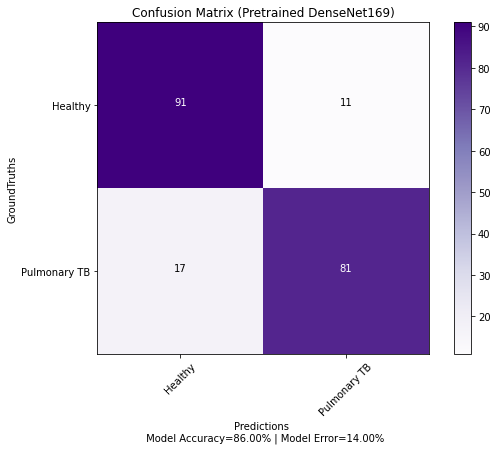

In [10]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('GroundTruths')
    plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
    plt.savefig('/content/drive/My Drive/GitHub Repositories/Tuberculosis/ReadMe Images/DenseNet169-cm.png', bbox_inches = "tight")
    plt.show()


predictions = model.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

test_y = tf.keras.backend.argmax(test_y_oneHot, axis=-1)
cm = confusion_matrix(test_y, predictions)
classes = ['Healthy', 'Pulmonary TB']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix (Pretrained DenseNet169)")


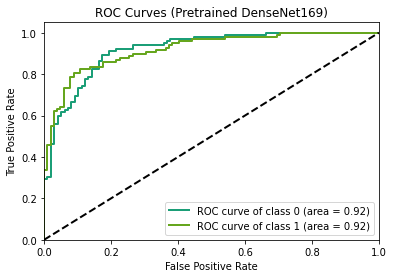

In [11]:
#Plot ROC Curve with Library
predictions = model.predict(x=test_x, batch_size=32)
# One can define colormap here
# cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
scikitplot.metrics.plot_roc(y_true=test_y, y_probas=predictions, title='ROC Curves (Pretrained DenseNet169)', plot_micro=False, plot_macro=False,
                            classes_to_plot=None, ax=None, figsize=(6, 4), cmap='Dark2', title_fontsize='large', text_fontsize='medium')
plt.savefig('/content/drive/My Drive/GitHub Repositories/Tuberculosis/ReadMe Images/DenseNet169-roc.png', bbox_inches = "tight")
plt.show()

/content/drive/My Drive/GitHub Repositories/Tuberculosis/Classification
2.2.0
(6, 224, 224, 3)


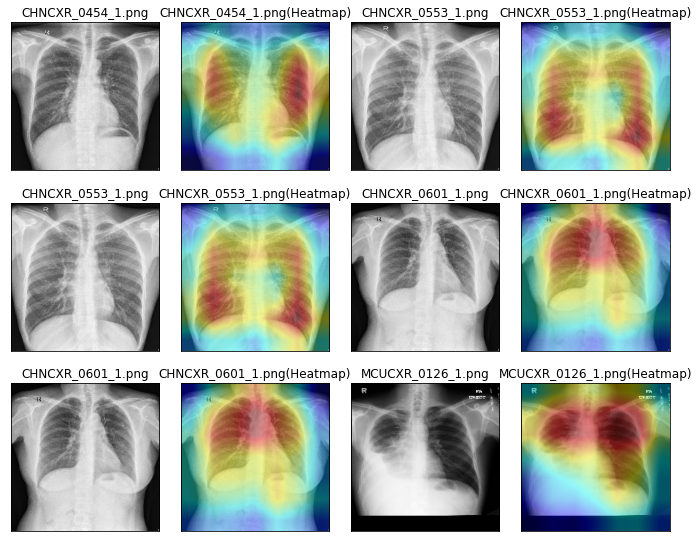

In [16]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%cd '/content/drive/My Drive/GitHub Repositories/Tuberculosis/Classification'

print(tf.__version__)
validDir =  './datasets/data/valid'
LAYER_NAME = 'relu'
# model = tf.keras.models.load_model('./saved Models/Classification/Pretrained VGG16/vgg16-best-model.h5')
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])


def GetHeatMap(img):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, np.argmax(predictions)]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    heatmap = cv2.addWeighted(np.uint8(255*img), 0.6, cam, 0.4, 0)
    return heatmap

imgSize = 224
channels = 3
imgNames = ['CHNCXR_0332_1.png', 'CHNCXR_0454_1.png', 'CHNCXR_0553_1.png', 'CHNCXR_0601_1.png', 'MCUCXR_0126_1.png', 'CHNCXR_0657_1.png']
images = []
for imgName in imgNames:
    imgPath = os.path.join(validDir, '1', imgName)
    img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(imgPath, target_size=(imgSize, imgSize)), dtype='float32')/255.0
    images.append(img)

images = np.array(images).reshape(-1, imgSize, imgSize, channels)
print(images.shape)

rows = 3
cols = 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
img_count =1
for r in range(rows):
    # plot image
    ax[r][0].imshow(images[img_count, :, :, :])
    ax[r][0].set_title(imgNames[img_count], fontsize=12)

    # plot heatmap
    ax[r][1].imshow(images[img_count, :, :, :])
    ax[r][1].imshow(GetHeatMap(images[img_count, :, :, :]))
    ax[r][1].set_title(imgNames[img_count]+ '(Heatmap)', fontsize=12)

    img_count+=1
    # plot pneumonia image
    ax[r][2].imshow(images[img_count, :, :, :])
    ax[r][2].set_title(imgNames[img_count], fontsize=12)

    # plot heatmap
    ax[r][3].imshow(images[img_count, :, :, :])
    ax[r][3].imshow(GetHeatMap(images[img_count, :, :, :]))
    ax[r][3].set_title(imgNames[img_count]+ '(Heatmap)', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0)
fig.savefig('/content/drive/My Drive/GitHub Repositories/Tuberculosis/ReadMe Images/denseNet169-visualization.png')
plt.show()
plt.close()